# 0. Librerías

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Preparación de datos (ya preprocesados) y de parámetros

In [29]:
X_train, X_test = np.load('x_training.npy'), np.load('x_testing.npy')
y_train, y_test = np.load('y_training.npy')[:,0] - 1, np.load('y_testing.npy')[:,0] - 1

"""
0 = Bottle
1 = Can
2 = Noise
3 = Paper
4 = Ping-pong
"""

INPUT_LENGTH = 4018
NUM_CLASSES = 5
LEARNING_RATE = 0.005

# 2. Architectura del modelo y entrenamiento

In [18]:
model = Sequential([
    Reshape((98, 41), input_shape=(INPUT_LENGTH,)),
    Conv1D(8, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Dropout(0.25),
    Conv1D(16, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(NUM_CLASSES, activation='softmax', name='y_pred')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 98, 41)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 98, 8)          │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 49, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 49, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 49, 16)         │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 25, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ y_pred (Dense)                  │ (None, 5)              │         2,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,397 (13.27 KB)

 Trainable params: 3,397 (13.27 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(X_train,y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
7/7 - 0s - 10ms/step - accuracy: 0.8136 - loss: 0.7794
Epoch 2/100
7/7 - 0s - 18ms/step - accuracy: 0.8136 - loss: 0.4567
Epoch 3/100
7/7 - 0s - 20ms/step - accuracy: 0.8409 - loss: 0.3613
Epoch 4/100
7/7 - 0s - 21ms/step - accuracy: 0.9136 - loss: 0.2502
Epoch 5/100
7/7 - 0s - 20ms/step - accuracy: 0.9409 - loss: 0.1897
Epoch 6/100
7/7 - 0s - 9ms/step - accuracy: 0.9273 - loss: 0.1853
Epoch 7/100
7/7 - 0s - 9ms/step - accuracy: 0.9545 - loss: 0.1761
Epoch 8/100
7/7 - 0s - 20ms/step - accuracy: 0.9636 - loss: 0.1597
Epoch 9/100
7/7 - 0s - 10ms/step - accuracy: 0.9455 - loss: 0.1777
Epoch 10/100
7/7 - 0s - 20ms/step - accuracy: 0.9636 - loss: 0.1318
Epoch 11/100
7/7 - 0s - 21ms/step - accuracy: 0.9545 - loss: 0.1369
Epoch 12/100
7/7 - 0s - 9ms/step - accuracy: 0.9636 - loss: 0.1100
Epoch 13/100
7/7 - 0s - 10ms/step - accuracy: 0.9682 - loss: 0.1209
Epoch 14/100
7/7 - 0s - 20ms/step - accuracy: 0.9818 - loss: 0.0992
Epoch 15/100
7/7 - 0s - 19ms/step - accuracy: 0.9773 - loss:

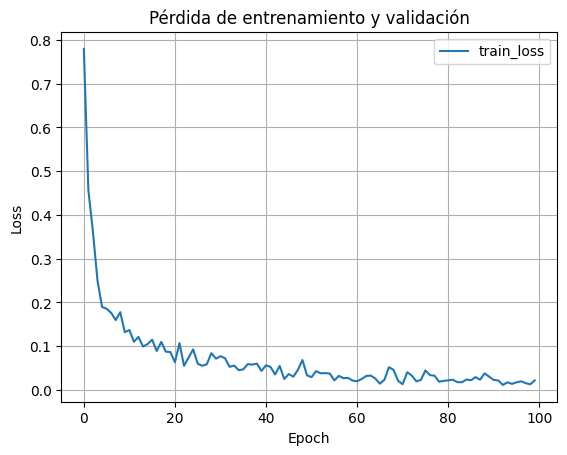

In [28]:
plt.plot(history.history['loss'], label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida de entrenamiento y validación')
plt.grid(True)
plt.show()

In [23]:
model.predict(X_train).shape

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


(220, 5)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


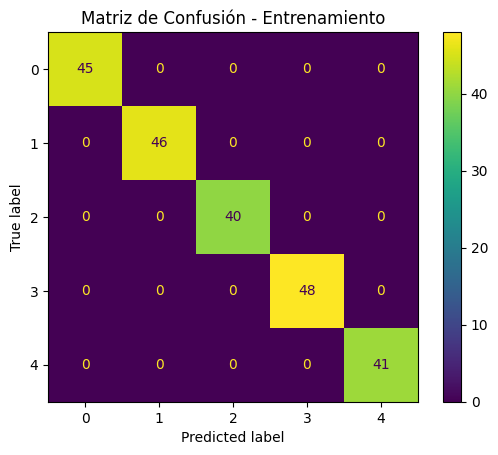

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


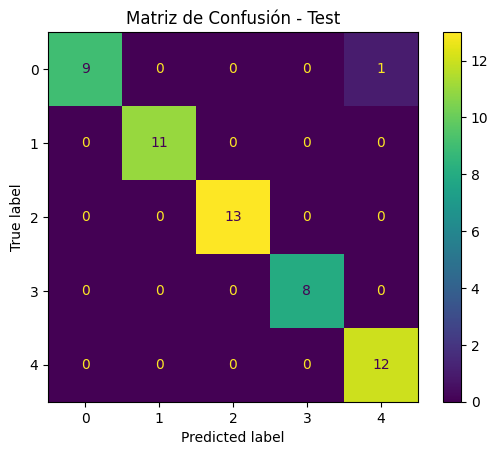

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Para TRAIN
y_pred_train = np.argmax(model.predict(X_train),axis=1)
cm_train = confusion_matrix(y_train, y_pred_train)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot()
plt.title("Matriz de Confusión - Entrenamiento")
plt.show()

# Para TEST
y_pred_test = np.argmax(model.predict(X_test), axis=1)
cm_test = confusion_matrix(y_test, y_pred_test)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title("Matriz de Confusión - Test")
plt.show()

# 3. Cuantización y exportaciṕn al ESP32

In [31]:
def representative_dataset_gen():
    for i in range(100):  # De forma arbitraria se decidió un sampling de 100
        sample = X_train[i].astype(np.float32)
        sample = np.expand_dims(sample, axis=0)  # shape = (1, 4018)
        yield [sample]

# Configurar el convertidor
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Paso clave: usar la función representativa
converter.representative_dataset = representative_dataset_gen

# Indicar que todo el modelo debe usar operaciones int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Forzar entrada y salida como int8 (lo que ESP32 espera)
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convertir el modelo
tflite_model = converter.convert()

# Guardar el modelo
with open("model_quantized_int8.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmps0fa15dz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4018), dtype=tf.float32, name='keras_tensor_30')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139226002814736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139226002816080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139226002815888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139226002814928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139226002816848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139225926010448: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
